In [1]:
import numpy as np
import xarray as xr
from pathlib import Path
from os.path import exists
import random
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
path_god = Path('/home/jovyan/Data/ECCO_GMSL/Beckley')
output_dir_main=Path('/home/jovyan/Data/ECCO_GMSL')
output_dir_missingdata=Path('/home/jovyan/Data/ECCO_GMSL/errors/missingdata')
output_dir_orbiterror=Path('/home/jovyan/Data/ECCO_GMSL/errors/orbiterror')
output_dir_orbiterror_missingdata=Path('/home/jovyan/Data/ECCO_GMSL/errors/orbiterror_missingdata')

# Create Sample file on 1 cycle of GSFC data

In [3]:
c=500
filename=str(path_god) + '/Merged_TOPEX_Jason_OSTM_Jason-3_Cycle_'+str(c).zfill(4)+'.V5_1.nc'
beckley=xr.open_mfdataset(filename)
beckley

<xarray.Dataset>
Dimensions:            (N_Records: 602812)
Coordinates:
    lat                (N_Records) float32 dask.array<chunksize=(602812,), meta=np.ndarray>
    lon                (N_Records) float32 dask.array<chunksize=(602812,), meta=np.ndarray>
    time               (N_Records) datetime64[ns] dask.array<chunksize=(602812,), meta=np.ndarray>
Dimensions without coordinates: N_Records
Data variables:
    index              (N_Records) int16 dask.array<chunksize=(602812,), meta=np.ndarray>
    reference_orbit    (N_Records) int16 dask.array<chunksize=(602812,), meta=np.ndarray>
    mssh               (N_Records) float64 dask.array<chunksize=(602812,), meta=np.ndarray>
    Distance_to_coast  (N_Records) float64 dask.array<chunksize=(602812,), meta=np.ndarray>
    Surface_Type       (N_Records) float32 dask.array<chunksize=(602812,), meta=np.ndarray>
    Bathymetry         (N_Records) float32 dask.array<chunksize=(602812,), meta=np.ndarray>
    flag               (N_Records) int16 dask.array<chunksize=(602812,), meta=np.ndarray>
    ssha               (N_Records) float64 dask.array<chunksize=(602812,), meta=np.ndarray>
    mss_modified       bool ...
    old_mssh           (N_Records) float64 dask.array<chunksize=(602812,), meta=np.ndarray>
    old_ssha           (N_Records) float32 dask.array<chunksize=(602812,), meta=np.ndarray>
Attributes: (12/46)
    Conventions:                   CF-1.7, ACDD-1.3
    title:                         Integrated Multi-Mission Ocean Altimeter D...
    summary:                       Geo-registered along-track sea surface hei...
    source:                        TOPEX/Poseidon MGDR_B: Benada, J.R. 1997. ...
    processing_level:              2
    featureType:                   trajectory
    ...                            ...
    geospatial_vertical_units:     mm
    geospatial_vertical_positive:  up
    geospatial_lat_resolution:     0.05
    geospatial_lon_resolution:     2.83
    geospatial_vertical_min:       -14993
    geospatial_vertical_max:       18453

In [4]:
time=beckley.time.values-beckley.time.values[0]
lat=beckley.lat.values
lon=beckley.lon.values
lon[np.where(lon>180)] = lon[np.where(lon>180)]-360
orbit_nb=beckley.reference_orbit.values

In [5]:
ds = xr.Dataset({"time": (("i"), time*10**(-9)),
            "y": (("i"), lat),
            "x": (("i"),lon),
            "orbit_nb": (("i"),orbit_nb)},
            coords={"i": range(0,len(lat))})
ds['time'].attrs['unit'] = 'seconds since cycle start'
ds['x'].attrs['unit'] = 'degrees'
ds['y'].attrs['unit'] = 'degrees'
ds['orbit_nb'].attrs['unit'] = ''
ds['time'].attrs['long_name'] = 'time in seconds since cycle start'
ds['x'].attrs['long_name'] = 'longitude'
ds['y'].attrs['long_name'] = 'latitude'
ds['orbit_nb'].attrs['long_name'] = 'orbit revolution number 1-127'
fileout=str(output_dir_main) + '/AlongTrack_sample.nc'
ds.to_netcdf(fileout)
ds

<xarray.Dataset>
Dimensions:   (i: 602812)
Coordinates:
  * i         (i) int64 0 1 2 3 4 5 ... 602807 602808 602809 602810 602811
Data variables:
    time      (i) timedelta64[ns] 00:00:00 ... 00:00:00.000856657
    y         (i) float32 2.303 2.353 2.402 2.451 ... -0.4123 -0.3632 -0.3142
    x         (i) float32 100.7 100.8 100.8 100.8 ... 99.76 99.78 99.79 99.81
    orbit_nb  (i) int16 1 1 1 1 1 1 1 1 1 ... 127 127 127 127 127 127 127 127

# Create a file per cycle with missing data

In [31]:
for c in range(1,1043): 
#1042 stops end of 2018 (we need more than end of 2017 as Beckley starts in Sept 1992)
    filename=str(path_god) + '/Merged_TOPEX_Jason_OSTM_Jason-3_Cycle_0500.V5_1.nc'
    beckley=xr.open_mfdataset(filename)
    orbit_nb=beckley.reference_orbit.values
    time=(beckley.time.values-beckley.time.values[0])*10**(-9)
    lat=beckley.lat.values
    lon=beckley.lon.values
    lat[:]=np.nan
    lon[:]=np.nan
    filename=str(path_god) + '/Merged_TOPEX_Jason_OSTM_Jason-3_Cycle_'+str(c).zfill(4)+'.V5_1.nc'
    if exists(filename):
        # print(c)
        beckley=xr.open_mfdataset(filename)

        beckley=beckley.where(np.isfinite(beckley.ssha)) #change all variables to nan where ssha is nan but not coordinates
        lat=beckley.lat.values
        lon=beckley.lon.values
        lon[np.where(lon>180)] = lon[np.where(lon>180)]-360
        ind=np.where(~np.isfinite(beckley.ssha))
        lat[ind]=np.nan
        lon[ind]=np.nan
        
    ds = xr.Dataset({"time": (("i"), time),
                "y": (("i"), lat),
                "x": (("i"),lon),
                "orbit_nb": (("i"),orbit_nb)},
                coords={"i": range(0,len(lat))})
    ds['time'].attrs['unit'] = 'seconds since cycle start'
    ds['x'].attrs['unit'] = 'degrees'
    ds['y'].attrs['unit'] = 'degrees'
    ds['orbit_nb'].attrs['unit'] = ''
    ds['time'].attrs['long_name'] = 'time in seconds since cycle start'
    ds['x'].attrs['long_name'] = 'longitude'
    ds['y'].attrs['long_name'] = 'latitude'
    ds['orbit_nb'].attrs['long_name'] = 'orbit revolution number 1-127'

    fileout=str(output_dir_missingdata) + '/AlongTrack_sample_'+str(c).zfill(4)+'_missingdata.nc'
    ds.to_netcdf(fileout)

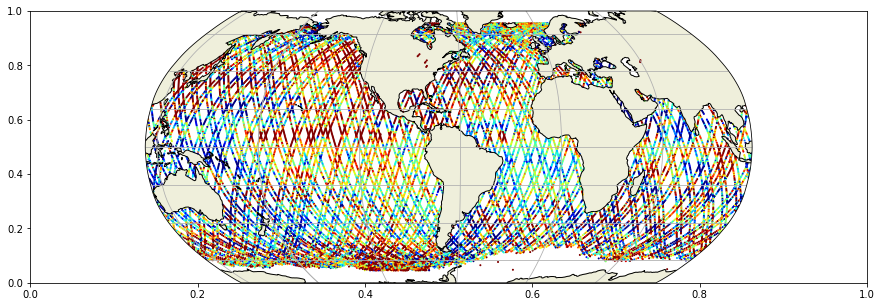

In [32]:
c=1
filename=str(path_god) + '/Merged_TOPEX_Jason_OSTM_Jason-3_Cycle_'+str(c).zfill(4)+'.V5_1.nc'
beckley=xr.open_mfdataset(filename)
beckley=beckley.where(np.isfinite(beckley.ssha),drop=True)
time=beckley.time.values-beckley.time.values[0]
lat=beckley.lat.values
lon=beckley.lon.values
lon[np.where(lon>180)] = lon[np.where(lon>180)]-360
ssh=beckley.ssha
        
fig = plt.figure(figsize=(15,5))
cm = plt.get_cmap('gist_rainbow')
ax=fig.gca()

ax = plt.axes(projection=ccrs.Robinson( \
              central_longitude=-67, globe=None))
ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

kk=12
p=ax.scatter(lon[::kk],\
             lat[::kk], \
             c=ssh[::kk], s=1,\
             transform=ccrs.PlateCarree(),
             vmin=-100,vmax=100, cmap='jet')

# Create a file per cycle with NO missing data and parameters for orbit error

### Test

In [8]:
c=500

filename=str(path_god) + '/Merged_TOPEX_Jason_OSTM_Jason-3_Cycle_'+str(c).zfill(4)+'.V5_1.nc'
beckley=xr.open_mfdataset(filename)

time=(beckley.time.values-beckley.time.values[0])*10**(-9)
time=time.astype(int)
lat=beckley.lat.values
lon=beckley.lon.values
lon[np.where(lon>180)] = lon[np.where(lon>180)]-360
orbit_nb=beckley.reference_orbit.values

In [9]:
period=6745 #~112 minutes for Jason 3
orbit_error=np.empty(len(orbit_nb))
orbit_error[:]=np.nan
orbit_nb_unique=np.unique(orbit_nb)
for i in orbit_nb_unique:
    ind=np.where(orbit_nb==i)
    amplitude=np.random.normal(0,0.01,1)
    phase=random.random()*2*np.pi
    orbit_error[ind]=amplitude*np.sin((time[ind[0]]-time[ind[0][0]])*2*np.pi/period + phase)

Text(0.5, 1.0, 'orbit error - 1 orbit')

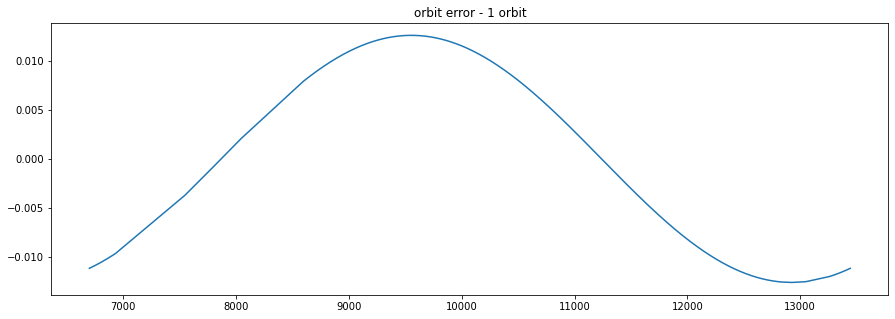

In [10]:
ind=np.where(orbit_nb==2) #tmax-tmin on that orbit is 6745 (max)
time[ind[0][-1]]-time[ind[0][0]]
fig = plt.figure(figsize=(15,5))
plt.plot(time[ind],orbit_error[ind])
plt.title('orbit error - 1 orbit')

Text(0.5, 1.0, 'orbit error - 1 orbit')

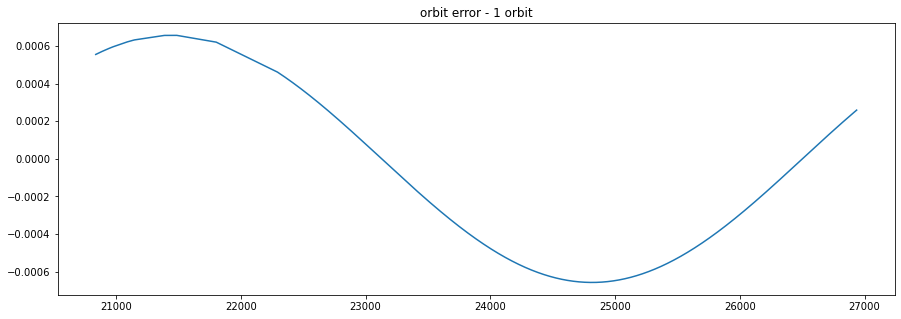

In [11]:
ind=np.where(orbit_nb==4) #tmax-tmin on that orbit is 6100
fig = plt.figure(figsize=(15,5))
plt.plot(time[ind],orbit_error[ind])
plt.title('orbit error - 1 orbit')

Text(0.5, 1.0, 'orbit error - 1 cycle')

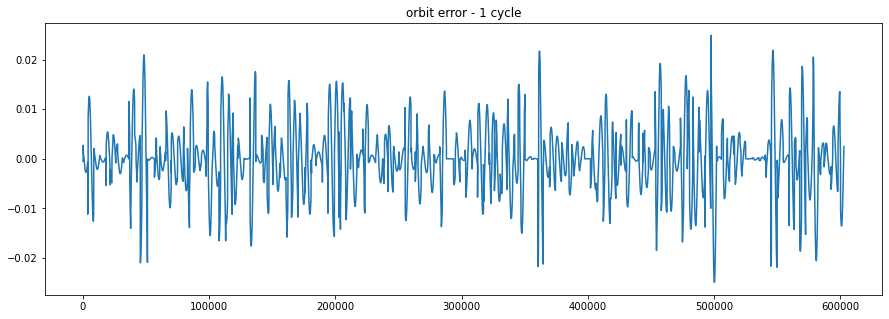

In [12]:
fig = plt.figure(figsize=(15,5))
plt.plot(orbit_error)
plt.title('orbit error - 1 cycle')

### All time series

In [ ]:
period=6745 #~112 minutes for Jason 3
filename=str(path_god)+'/Merged_TOPEX_Jason_OSTM_Jason-3_Cycle_0500.V5_1.nc' #we use the same cycle over and over as in the sample file but the orbit error changes in each orbit and each cycle
beckley=xr.open_mfdataset(filename)
for c in range(1,1043): #cycle Goddard: c+862 (cycle 521 missing)
    print(c)
    time=(beckley.time.values-beckley.time.values[0])*10**(-9)
    lat=beckley.lat.values
    lon=beckley.lon.values
    lon[np.where(lon>180)] = lon[np.where(lon>180)]-360
    orbit_nb=beckley.reference_orbit.values

    orbit_error=np.empty(len(orbit_nb))
    orbit_error[:]=np.nan
    orbit_nb_unique=np.unique(orbit_nb)
    for i in orbit_nb_unique:
        ind=np.where(orbit_nb==i)
        amplitude=np.random.normal(0,0.01,1)
        phase=random.random()*2*np.pi
        orbit_error[ind]=amplitude*np.sin((time.astype(int)[ind[0]]-time.astype(int)[ind[0][0]])*2*np.pi/period + phase)

    ds = xr.Dataset({"time": (("i"), time),
                "y": (("i"), lat),
                "x": (("i"),lon),
                "orbit_nb": (("i"),orbit_nb),
                "orbit_error": (("i"),orbit_error)},
                coords={"i": range(0,len(lat))})
    ds['time'].attrs['unit'] = 'seconds since cycle start'
    ds['x'].attrs['unit'] = 'degrees'
    ds['y'].attrs['unit'] = 'degrees'
    ds['orbit_nb'].attrs['unit'] = ''
    ds['orbit_error'].attrs['unit'] = 'cm'
    ds['time'].attrs['long_name'] = 'time in seconds since cycle start'
    ds['x'].attrs['long_name'] = 'longitude'
    ds['y'].attrs['long_name'] = 'latitude'
    ds['orbit_error'].attrs['long_name'] = 'orbit error = amplitude * sin(2 pi t/T + phase)'
    ds['orbit_nb'].attrs['long_name'] = 'orbit revolution number 1-127'

    fileout=str(output_dir_orbiterror) + '/AlongTrack_sample_'+str(c).zfill(4)+'_orbiterror.nc'
    ds.to_netcdf(fileout)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


# Create a file per cycle with missing data AND parameters for orbit error

In [30]:
period=6745 #~112 minutes for Jason 3
for c in range(1,1043): #cycle Goddard: c+862 (cycle 521 missing)
    filename=str(path_god) + '/Merged_TOPEX_Jason_OSTM_Jason-3_Cycle_0500.V5_1.nc'
    beckley=xr.open_mfdataset(filename)
    orbit_nb=beckley.reference_orbit.values
    time=(beckley.time.values-beckley.time.values[0])*10**(-9)
    lat=beckley.lat.values
    lon=beckley.lon.values
    lat[:]=np.nan
    lon[:]=np.nan
    
    filename=str(path_god)+'/Merged_TOPEX_Jason_OSTM_Jason-3_Cycle_'+str(c).zfill(4)+'.V5_1.nc'
    if exists(filename):
        # print(c)
        beckley=xr.open_mfdataset(filename)

        beckley=beckley.where(np.isfinite(beckley.ssha))
        lat=beckley.lat.values
        lon=beckley.lon.values
        lon[np.where(lon>180)] = lon[np.where(lon>180)]-360
        ind=np.where(~np.isfinite(beckley.ssha))
        lat[ind]=np.nan
        lon[ind]=np.nan
        
        orbit_error=np.empty(len(orbit_nb))
        orbit_error[:]=np.nan
        orbit_nb_unique=np.unique(orbit_nb)
        for i in orbit_nb_unique:
            ind=np.where(orbit_nb==i)
            amplitude=np.random.normal(0,0.01,1)
            phase=random.random()*2*np.pi
            orbit_error[ind]=amplitude*np.sin((time.astype(int)[ind[0]]-time.astype(int)[ind[0][0]])*2*np.pi/period + phase)
        
    ds = xr.Dataset({"time": (("i"), time),
                "y": (("i"), lat),
                "x": (("i"),lon),
                "orbit_nb": (("i"),orbit_nb),
                "orbit_error": (("i"),orbit_error)},
                coords={"i": range(0,len(lat))})
    ds['time'].attrs['unit'] = 'seconds since cycle start'
    ds['x'].attrs['unit'] = 'degrees'
    ds['y'].attrs['unit'] = 'degrees'
    ds['orbit_nb'].attrs['unit'] = ''
    ds['orbit_error'].attrs['unit'] = 'cm'
    ds['time'].attrs['long_name'] = 'time in seconds since cycle start'
    ds['x'].attrs['long_name'] = 'longitude'
    ds['y'].attrs['long_name'] = 'latitude'
    ds['orbit_error'].attrs['long_name'] = 'orbit error = amplitude * sin(2 pi t/T + phase)'
    ds['orbit_nb'].attrs['long_name'] = 'orbit revolution number 1-127'

    fileout=str(output_dir_orbiterror_missingdata) + '/AlongTrack_sample_'+str(c).zfill(4)+'_orbiterror_missingdata.nc'
    ds.to_netcdf(fileout)   